In [1]:
import json
import os
import pickle
import re
import itertools
from __future__ import print_function
from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.decomposition import PCA
from nltk.stem.snowball import SnowballStemmer
from sklearn.grid_search import GridSearchCV
from sklearn.naive_bayes import GaussianNB,BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn import metrics
import numpy as np
from matplotlib import pyplot as plt

C:\Users\saboo.Varun\Anaconda2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\saboo.Varun\Anaconda2\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
plt.style.use('dark_background')
washington_words = ['Seattle','Washington','WA','Kirkland','Spokane',
                    'Vancouver','Bellevue','Everett','Yakima','Redmond','Kent','Tacoma']
washington_anti = ['DC','D.C','D.C.']
massachusetts_words = ['MA','Massachusetts','Boston','Worcester','Springfield',
                       'Lowell','Arlington','Bedford','Brockton','Quincy','Lynn',
                       'New England','Cambridge']
massachusetts_anti = ['Ohio']

In [9]:
def read_data(filename,subset=False):
    
    def location_condition(location,loc1_words,loc2_words,loc1_anti,loc2_anti):
        if ((any(word in location for word in loc1_words) and 
            not any(word in location for word in loc1_anti)) or 
            (any(word in location for word in loc2_words) and 
            not any(word in location for word in loc2_anti))):
            return True
        return False
    
    data = []
    if(subset):
        n_rows=1000
        count=0
    with open(filename) as fp:
        for line in fp:
            entry = json.loads(line)
            if(location_condition(entry['tweet']['user']['location'],
                                  washington_words,massachusetts_words,
                                  washington_anti,massachusetts_anti)):
                data.append(entry['tweet'])
                if(subset):
                    count+=1
                    if(count==n_rows):
                        break
    return data

def get_tweets(data):
    values = []
    for entry in data:
        values.append(entry['text'])
    return values

def get_locations(data):
    values = []
    for entry in data:
        values.append(entry['user']['location'])
    return values


def get_labeled_data(tweets,locations,loc1_words,loc2_words,loc1_anti,loc2_anti):
    labels=[]
    data = []
    for index,loc in enumerate(locations):
        if (any(word in loc for word in loc1_words) and 
            not any(word in loc for word in loc1_anti)):
            data.append(tweets[index])
            labels.append(1)
        elif (any(word in loc for word in loc2_words) and 
            not any(word in loc for word in loc2_anti)):
            data.append(tweets[index])
            labels.append(-1)
    return [preprocess_tweets(data),labels]

def preprocess_tweets(data):
    processed_tweets = []
    emoticons_str = r"""
        (?:
            [:=;] # Eyes
            [oO\-]? # Nose (optional)
            [D\)\]\(\]/\\OpP] # Mouth
        )"""
    html_str = r'<[^>]+>'
    mention_str = r'(?:@[\w_]+)'
    hash_tag_str = r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)"
    url_str = r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+'
    numbers_str = r'(?:(?:\d+,?)+(?:\.?\d+)?)'
    regex_str = [
        emoticons_str, html_str, mention_str,
        hash_tag_str, url_str, numbers_str,
        r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
        r'(?:[\w_]+)', # other words
    ]

    delete_str = [
        emoticons_str, html_str, mention_str,
        url_str, numbers_str, r'RT'
    ]

    tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
    emoticon_re = re.compile(r'^'+emoticons_str+'$', re.VERBOSE | re.IGNORECASE)
    delete_re = re.compile(r'('+'|'.join(delete_str)+')', re.VERBOSE | re.IGNORECASE)

    def tokenize(s):
        return tokens_re.findall(s)

    def preprocess(s, lowercase=True):
        tokens = tokenize(s)
        if lowercase:
            tokens = [token.lower() for token in tokens if not delete_re.search(token)]
        return ' '.join(tokens)

    for tweet in data:
        processed_tweets.append(preprocess(tweet))
    return processed_tweets

def init_params():
    stemmer = SnowballStemmer('english')
    analyzer = CountVectorizer().build_analyzer()
    vectorizer = CountVectorizer(stop_words='english', min_df=2, max_df=0.95, analyzer=stem_words)
    tfidf_transformer = TfidfTransformer(norm='l2', sublinear_tf=True)
    return [stemmer,analyzer,vectorizer,tfidf_transformer]

def stem_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

def get_tfidf(vectorizer,tfidf_transformer,data,isTraining=True):
    if(isTraining):
        count_data = vectorizer.fit_transform(data)
        tfidf_data = tfidf_transformer.fit_transform(count_data)
    else:
        count_data = vectorizer.transform(data)
        tfidf_data = tfidf_transformer.transform(count_data)        
    return tfidf_data

In [12]:
def get_data(filename=None,dataset='train',precomputed=True,subset=False):
    if(filename is None):
        precomputed = True
    if(not precomputed):
        if not os.path.exists(os.path.join('data',dataset,'part2')):
            os.makedirs(os.path.join('data',dataset,'part2'))
        superbowl = read_data(os.path.join('data',dataset,filename),subset=subset)
        tweets = get_tweets(superbowl)
        locations = get_locations(superbowl)
        data,labels = get_labeled_data(tweets,locations,washington_words,massachusetts_words,
                                       washington_anti,massachusetts_anti)
        name = filename[:filename.index('.')]+'.pkl'
        pickle_filename = os.path.join('data',dataset,'part2',name)
        with(open(pickle_filename,'wb')) as fp:
            pickle.dump([data,labels],fp,protocol=2)
    else:
        name = filename[:filename.index('.')]+'.pkl'
        pickle_filename = os.path.join('data',dataset,'part2',name)
        with(open(pickle_filename,'rb')) as fp:
            data,labels = pickle.load(fp)
        if subset:
            data,labels = data[:1000],labels[:1000]
    return data,labels

data,labels = get_data('tweets_#superbowl.txt',precomputed=True)
print('Number of tweets =',len(data))

Number of tweets = 54663


In [36]:
load_tfidf_data = True
pickleFile = os.path.join('data','train','part2','tfidf.pkl')

if(not load_tfidf_data):
    stemmer,analyzer,vectorizer,tfidf_transformer = init_params()
    tweets_train,tweets_test,train_labels,test_labels = train_test_split(data,labels,
                                                                     test_size=0.2,
                                                                     random_state=42)
    train_labels = np.array(train_labels)
    test_labels = np.array(test_labels)
    tweets_train = get_tfidf(vectorizer,tfidf_transformer,tweets_train)
    tweets_test = get_tfidf(vectorizer,tfidf_transformer,tweets_test,isTraining=False)
 
    with open(pickleFile,'wb') as fp:
        pickle.dump({'tweets_train':tweets_train,'tweets_test':tweets_test,
                     'train_labels':train_labels,'test_labels':test_labels},fp)
else:
    with open(pickleFile,'rb') as fp:
        pickle_data = pickle.load(fp)
        tweets_train = pickle_data['tweets_train']
        tweets_test = pickle_data['tweets_test']
        train_labels = pickle_data['train_labels']
        test_labels = pickle_data['test_labels']
        
print('Shape of Training Data =', tweets_train.shape)
print('Shape of Testing Data =', tweets_test.shape)
print('# of Washington Labels in training=', sum(train_labels==1))
print('# of Massachusetts Labels in training=', sum(train_labels==-1))
print('# of Washington Labels in testing=', sum(test_labels==1))
print('# of Massachusetts Labels in testing=', sum(test_labels==-1))

Shape of Training Data = (43730, 9079)
Shape of Testing Data = (10933, 9079)
# of Washington Labels in training= 22001
# of Massachusetts Labels in training= 21729
# of Washington Labels in testing= 5460
# of Massachusetts Labels in testing= 5473


In [21]:
def get_lsi(data,dim,lsi=None,train=True):
    if(train):
        lsi = TruncatedSVD(n_components=dim, n_iter=7, random_state=42)
        lsi_data = lsi.fit_transform(data)
    else:
        lsi_data = lsi.transform(data)
    return lsi,lsi_data

def get_nmf(data,dim,nmf=None,train=True):
    if(train):
        nmf = NMF(n_components=dim, init='random', random_state=42)
        nmf_data = nmf.fit_transform(data)
    else:
        nmf_data = nmf.transform(data)
    return nmf,nmf_data

def reduced_dimension(dim_reduce,train_data=None,test_data=None,precomputed=False,dim=50):
    pickleFile = os.path.join('data','train','part2',dim_reduce+'.pkl')
    if(precomputed):
        with open(pickleFile,'rb') as fp:
            dim_reduce_dict = pickle.load(fp)
        model = dim_reduce_dict['model']
        train_data = dim_reduce_dict['train']
        test_data = dim_reduce_dict['test']
    else:
        if(dim_reduce == 'lsi'):
            method = get_lsi
        else:
            method = get_nmf
        model,train_data = method(train_data,dim)
        _,test_data = method(test_data,dim,model,train=False)
        with open(pickleFile,'wb') as fp:
            pickle.dump({'model':model,'train':train_data,'test':test_data},fp)
    return train_data,test_data

#### Visualization of Separability

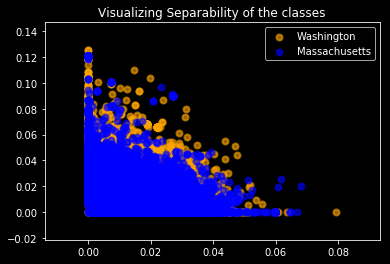

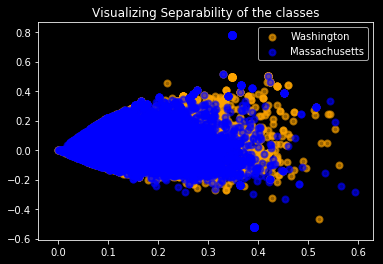

In [22]:
def visualize(data,labels,target_names):
    #Visualization
    colors = ['orange', 'blue']
    for color, i, target_name in zip(colors, [1,-1], target_names):
        plt.scatter(data[labels == i, 0], data[labels == i, 1], color=color, alpha=.6, lw=2,
                    label=target_name)
    plt.legend(loc='best', labels=target_names)
    plt.title('Visualizing Separability of the classes')
    plt.show()

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Spectral):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    fig=plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "%.2f"%cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
def plot_roc_curve(fpr,tpr,algo):
    roc_auc = metrics.auc(fpr,tpr)
    fig=plt.figure(figsize=(8,8))
    plt.title(''.join(['ROC - ',algo]))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.plot(fpr,tpr,'b',label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.show()
    
_,visualize_data = get_nmf(tweets_train,2)    
target_names = ['Washington','Massachusetts']
visualize(visualize_data,train_labels,target_names)
_,visualize_data = get_lsi(tweets_train,2)    
visualize(visualize_data,train_labels,target_names)

In [23]:
lsi_train,lsi_test = reduced_dimension('lsi',tweets_train,tweets_test,precomputed=True,dim=50)
nmf_train,nmf_test = reduced_dimension('nmf',tweets_train,tweets_test,precomputed=True,dim=50)

#### Naive Bayes - Bernoulli

Accuracy of model = 0.662672642459
Precision of model = 0.660805860806
Recall of model = 0.662747979427


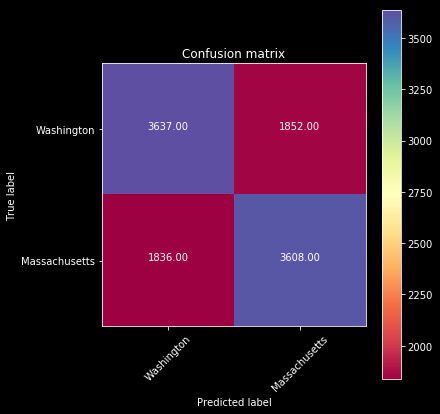

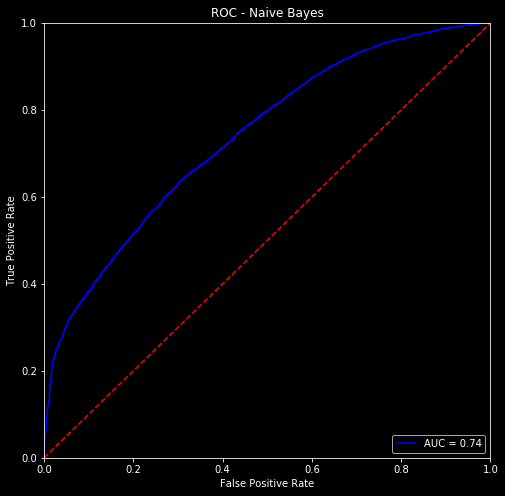

In [25]:
def naive_bayes(X_train,X_test,y_train,y_test,target_names):
    gnb = BernoulliNB().fit(X_train, y_train)
    y_pred = gnb.predict(X_test)
    print('Accuracy of model =',metrics.accuracy_score(y_pred,y_test))
    print('Precision of model =',metrics.precision_score(y_pred,y_test))
    print('Recall of model =',metrics.recall_score(y_pred,y_test))
    cfm = metrics.confusion_matrix(y_pred,y_test)
    plot_confusion_matrix(cfm,target_names)
    y_pred = gnb.predict_proba(X_test)
    fpr,tpr,_ = metrics.roc_curve(y_test, y_pred[:,1])
    plot_roc_curve(fpr,tpr,'Naive Bayes')

naive_bayes(lsi_train,lsi_test,train_labels,test_labels,target_names)
#naive_bayes(nmf_train,nmf_test,train_labels,test_labels,target_names)

#### SVM

# Tuning hyper-parameters for accuracy - lsi
Best parameters set found on development set:
{'kernel': 'rbf', 'C': 10}
Grid scores on development set:
0.540 (+/-0.000) for {'kernel': 'rbf', 'C': 0.01}
0.643 (+/-0.004) for {'kernel': 'linear', 'C': 0.01}
0.540 (+/-0.000) for {'kernel': 'poly', 'C': 0.01}
0.642 (+/-0.004) for {'kernel': 'rbf', 'C': 0.1}
0.683 (+/-0.005) for {'kernel': 'linear', 'C': 0.1}
0.540 (+/-0.000) for {'kernel': 'poly', 'C': 0.1}
0.683 (+/-0.005) for {'kernel': 'rbf', 'C': 1}
0.687 (+/-0.006) for {'kernel': 'linear', 'C': 1}
0.540 (+/-0.000) for {'kernel': 'poly', 'C': 1}
0.688 (+/-0.005) for {'kernel': 'rbf', 'C': 10}
0.687 (+/-0.006) for {'kernel': 'linear', 'C': 10}
0.540 (+/-0.000) for {'kernel': 'poly', 'C': 10}
Detailed classification report:
Accuracy of model = 0.688025774118
Precision of model = 0.8465085639
Recall of model = 0.668053028334


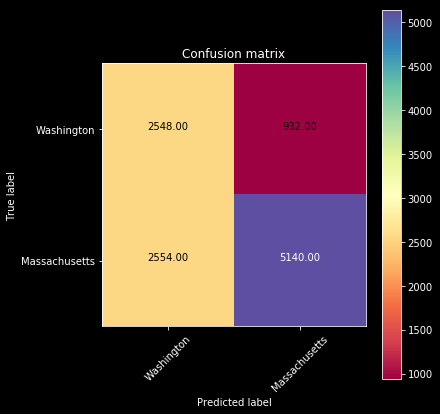

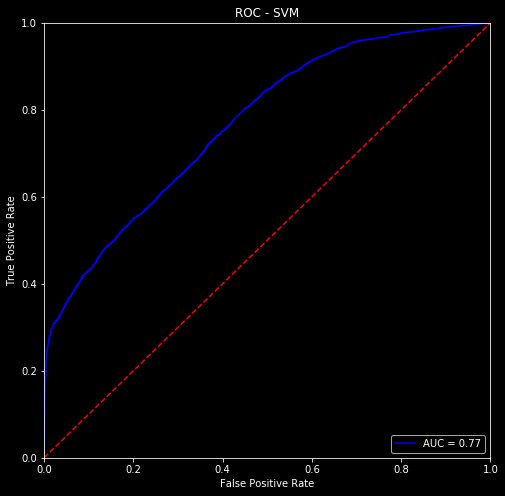

In [11]:
def svm_function(X_train,X_test,y_train,y_test,target_names,typ):
    tuned_parameters = [{'kernel': ['rbf','linear','poly']}]
    scores = ['accuracy']
    for score in scores:
        print("# Tuning hyper-parameters for {0} - {1}".format(score,typ))
        clf = GridSearchCV(svm.SVC(C=10,probability=True), tuned_parameters, cv=1,
                           scoring=score, n_jobs=5)
        clf.fit(X_train, y_train)

        print("Best parameters set found on development set:")
        print(clf.best_params_)
        print("Grid scores on development set:")
        for params, mean_score, scores in clf.grid_scores_:
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean_score, scores.std() * 2, params))
        print("Detailed classification report:")
        y_pred = clf.predict(X_test)
        print('Accuracy of model =',metrics.accuracy_score(y_pred,y_test))
        print('Precision of model =',metrics.precision_score(y_pred,y_test))
        print('Recall of model =',metrics.recall_score(y_pred,y_test))
        cfm = metrics.confusion_matrix(y_pred,y_test)
        plot_confusion_matrix(cfm,target_names)
        y_preds = clf.predict_proba(X_test)
        fpr,tpr,_ = metrics.roc_curve(y_test, y_preds[:,1])
        plot_roc_curve(fpr,tpr,'SVM')

svm_function(lsi_train,lsi_test,train_labels,test_labels,target_names,'lsi')
#svm_function(nmf_train,nmf_test,train_labels,test_labels,target_names,'nmf')

#### Logistic Regression

Accuracy of model = 0.708680142687
Precision of model = 0.541025641026
Recall of model = 0.813102119461


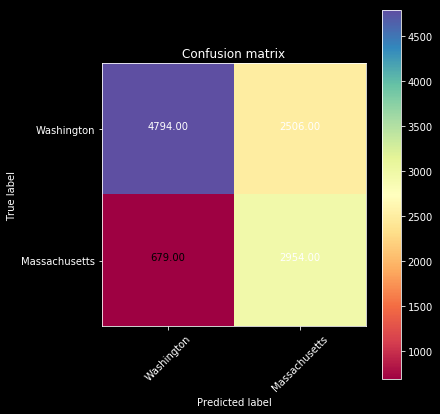

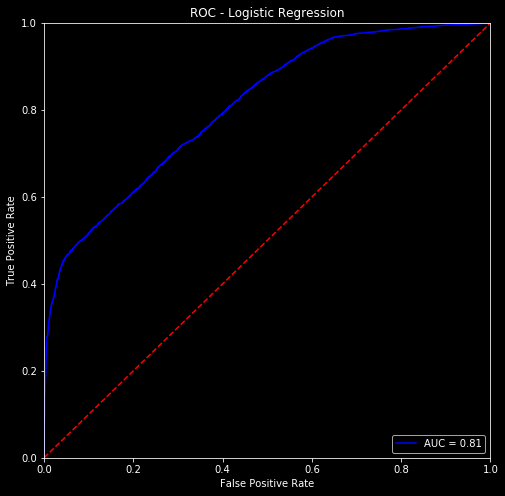

In [35]:
def logistic_regression(X_train,X_test,y_train,y_test,target_names):
    model = LogisticRegression(C=10, penalty='l2').fit(X_train,y_train)
    y_pred = model.predict(X_test)
    print('Accuracy of model =',metrics.accuracy_score(y_pred,y_test))
    print('Precision of model =',metrics.precision_score(y_pred,y_test))
    print('Recall of model =',metrics.recall_score(y_pred,y_test))
    cfm = metrics.confusion_matrix(y_pred,y_test)
    plot_confusion_matrix(cfm,target_names)
    y_preds = model.predict_proba(X_test)
    fpr,tpr,_ = metrics.roc_curve(y_test, y_preds[:,1])
    plot_roc_curve(fpr,tpr,'Logistic Regression')

logistic_regression(lsi_train,lsi_test,train_labels,test_labels,target_names)